In [1]:
import sys
sys.path.insert(0, "../scripts")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
from fbprophet import Prophet
#from decprophet import DecProphet
from decpredict import DecProphet, DecARIMA
from decsma import DecSMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\ariel\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
plt.rcParams["figure.figsize"] = [16,4]
pd.plotting.register_matplotlib_converters()

In [4]:
def prepare_data(data, dummies=False):
    start_date = "2019-06-01"
    end_date = "2019-07-31"
    #end_date = "2019-08-07"
    data = orig_data[["fecha", "potencia", "nub"]]
    data = data.rename(columns={"fecha":"ds", "potencia":"y"})
    data = data.set_index("ds")[start_date:end_date]
    data = data.reset_index()
    data.nub = data.nub.fillna(method="ffill").astype("int64")
    if dummies:
        data = pd.get_dummies(data, columns=["nub"], drop_first=True)
    return data

In [5]:
def split_data(data, split_dt):
    split_idx = data[data.ds == split_dt].index[0]
    train = data.iloc[:split_idx].copy()
    test = data.iloc[split_idx:].copy()
    return train, test

In [6]:
def performance(true, pred):
    RMSE_val = np.sqrt(MSE(true, pred))
    MAE_val = MAE(true, pred)
    return RMSE_val, MAE_val

In [7]:
orig_data = pd.read_csv("../data/tabla_generacion_energia.csv", parse_dates=["fecha"])

In [8]:
orig_data

,fecha,potencia,temp,hum,presion,dir,vel,nub,situacion
0,2019-05-30 12:00:00,866.133333,5.0,90.0,1023.1,E,9.4,8.0,Cubierto
1,2019-05-30 13:00:00,732.900000,6.4,88.0,1023.5,E,3.6,8.0,Cubierto
2,2019-05-30 14:00:00,455.018868,7.6,83.0,1023.4,SE,11.2,7.0,Nuboso
3,2019-05-30 15:00:00,191.666667,8.4,75.0,1022.9,E,14.8,7.0,Nuboso
4,2019-05-30 16:00:00,60.366667,9.6,66.0,1022.3,E,16.6,6.0,Nuboso
...,...,...,...,...,...,...,...,...,...
2331,2019-09-04 15:00:00,514.733333,8.6,42.0,1031.0,S,33.5,3.0,Nubes dispersas
2332,2019-09-04 16:00:00,251.050000,8.6,39.0,1031.0,S,25.9,6.0,Nuboso
2333,2019-09-04 17:00:00,85.779661,8.7,33.0,1030.9,S,29.5,8.0,"Cubierto, precipitación a la vista"
2334,2019-09-04 18:00:00,4.150000,7.7,41.0,1030.9,S,27.7,7.0,Nuboso


In [89]:
data = prepare_data(orig_data)

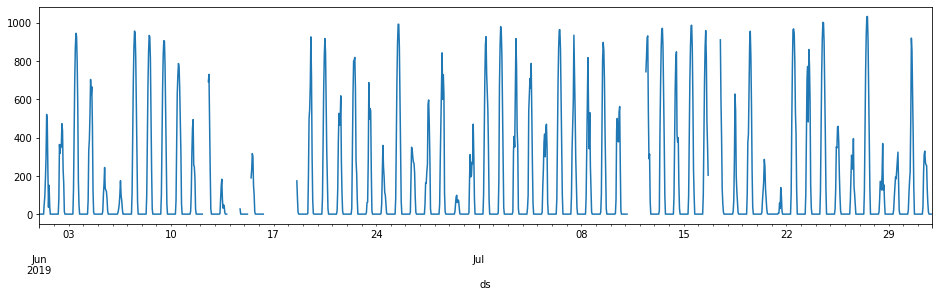

In [38]:
data.set_index("ds").y.plot()

In [90]:
train, test = split_data(data, "2019-07-25")

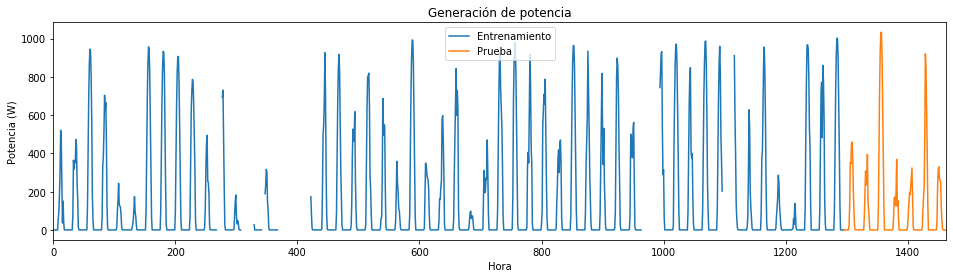

In [91]:
train.y.plot()
test.y.plot()
plt.title("Generación de potencia")
plt.xlabel("Hora")
plt.ylabel("Potencia (W)")
plt.legend(["Entrenamiento", "Prueba"]);

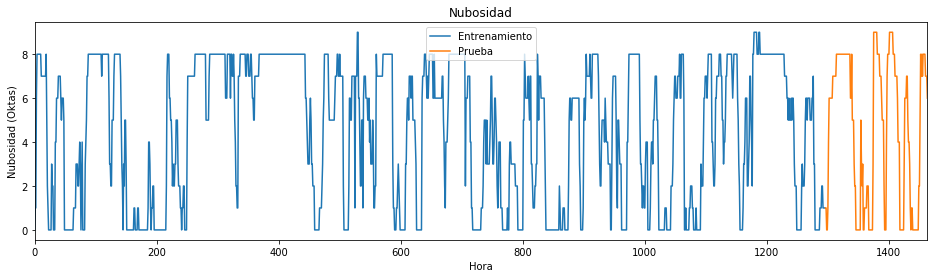

In [94]:
train.nub.plot()
test.nub.plot()
plt.title("Nubosidad")
plt.xlabel("Hora")
plt.ylabel("Nubosidad (Oktas)")
plt.legend(["Entrenamiento", "Prueba"], loc="upper center");

# Prophet

In [233]:
data = prepare_data(orig_data, dummies=True)

In [234]:
regressors = list(data.drop(columns=["y", "ds"]).columns)

In [235]:
train, test = split_data(data, "2019-07-25")
#train, test = split_data(data, "2019-08-01")

In [236]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True, holidays_prior_scale=10)

In [237]:
for reg in regressors:
    model.add_regressor(reg)

In [238]:
model.fit(train)

In [239]:
future = model.make_future_dataframe(len(test), freq="H", include_history=False)

In [240]:
future = future.merge(test[["ds"] + regressors], left_on="ds", right_on="ds")

In [241]:
forecast = model.predict(future)

In [242]:
forecast.loc[forecast.yhat < 0, "yhat"] = 0

In [243]:
forecast.index = test.index

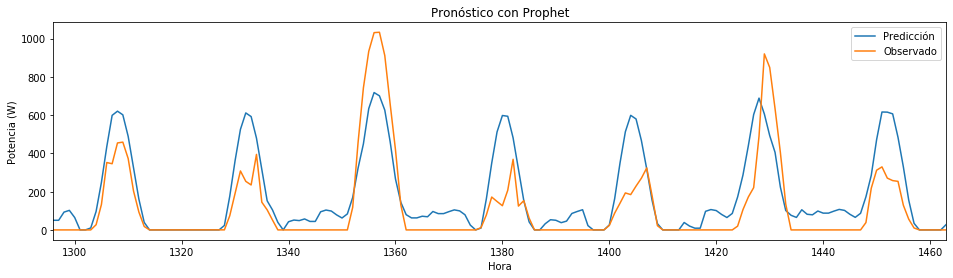

In [244]:
forecast.yhat.plot()
test.y.plot()
plt.title("Pronóstico con Prophet")
plt.xlabel("Hora")
plt.ylabel("Potencia (W)")
plt.legend(["Predicción", "Observado"])

In [245]:
performance(forecast.set_index("ds").yhat, test.set_index("ds").y)

(147.56029012422155, 101.54916567188204)

### With time as regressor

In [233]:
data = prepare_data(orig_data, dummies=True)

In [234]:
data["hour"] = data.ds.dt.hour
data["day"] = data.ds.dt.dayofyear

In [235]:
train, test = split_data(data, "2019-07-25")

In [236]:
regressors = list(data.drop(columns=["y", "ds"]).columns)

In [238]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)

In [239]:
for reg in regressors:
    model.add_regressor(reg)

In [240]:
model.fit(train)

In [241]:
future = model.make_future_dataframe(len(test), freq="H", include_history=False)

In [242]:
future = future.merge(test[["ds"] + regressors], left_on="ds", right_on="ds")

In [243]:
forecast = model.predict(future)

In [244]:
forecast.loc[forecast.yhat < 0, "yhat"] = 0

In [245]:
forecast.index = test.index

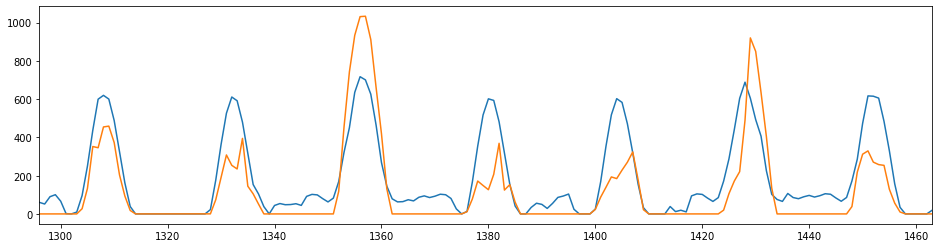

In [246]:
forecast.yhat.plot()
test.y.plot()

# DecProphet

In [9]:
data = prepare_data(orig_data, dummies=True)

In [10]:
train, test = split_data(data, split_dt="2019-07-25")
#train, test = split_data(data, split_dt="2019-08-01")

In [11]:
regressors = list(data.drop(columns=["ds", "y"]).columns)

In [12]:
model = DecProphet(exog=regressors)

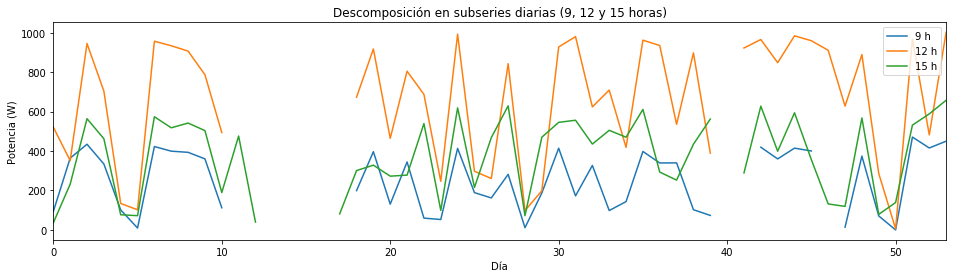

In [37]:
model.decompose(train)[9].y.plot()
#model.decompose(train)[10].y.plot()
#model.decompose(train)[11].y.plot()
model.decompose(train)[12].y.plot()
#model.decompose(train)[13].y.plot()
#model.decompose(train)[14].y.plot()
model.decompose(train)[15].y.plot()
#model.decompose(train)[16].y.plot()
plt.title("Descomposición en subseries diarias (9, 12 y 15 horas)")
plt.xlabel("Día")
plt.ylabel("Potencia (W)")
plt.legend(["9 h", "12 h", "15 h"])

In [13]:
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [14]:
forecast = model.predict(test)

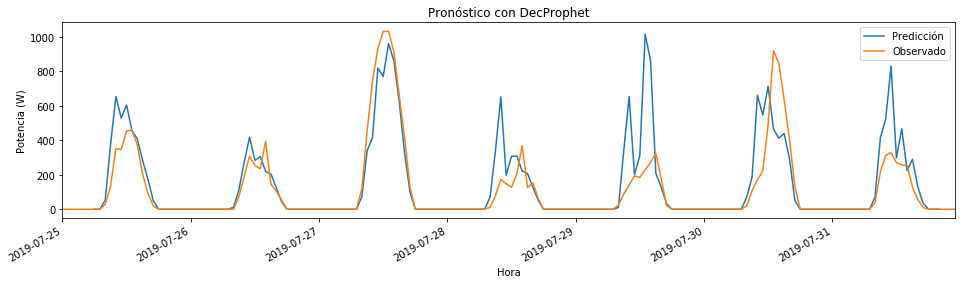

In [15]:
forecast.set_index("ds").yhat.interpolate().plot()
test.set_index("ds").y.plot()
plt.title("Pronóstico con DecProphet")
plt.xlabel("Hora")
plt.ylabel("Potencia (W)")
plt.legend(["Predicción", "Observado"])

In [16]:
def performance(pred, true):
    se = (pred - true)**2
    ae = (pred - true).abs()
    rmse = np.sqrt(se.fillna(0).mean())
    mae = ae.fillna(0).mean()
    return rmse, mae

In [17]:
performance(forecast.set_index("ds").yhat, test.set_index("ds").y)

(144.14735034444735, 63.53334307298625)

# SMA

In [208]:
data = prepare_data(orig_data, dummies=False)

In [209]:
train, test = split_data(data, split_dt="2019-07-25")

In [210]:
model = DecSMA(exog="nub")

In [211]:
model.fit(train)

In [212]:
forecast = model.predict(test).interpolate()

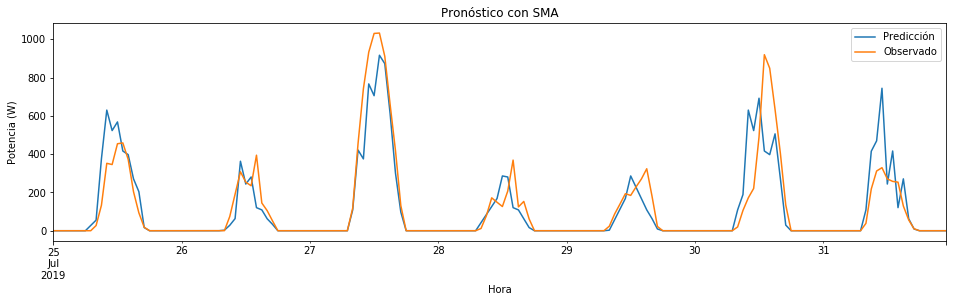

In [213]:
forecast.set_index("ds").yhat.interpolate().plot()
test.set_index("ds").y.plot()
plt.title("Pronóstico con SMA")
plt.xlabel("Hora")
plt.ylabel("Potencia (W)")
plt.legend(["Predicción", "Observado"])

In [217]:
performance(test.set_index("ds").y, forecast.set_index("ds").yhat)

(108.06819353932875, 48.71441858246314)

# Random Forest

In [221]:
data = prepare_data(orig_data).dropna()
data = data.set_index("ds")

In [222]:
data["hour"] = data.index.hour
data["day"] = data.index.dayofyear

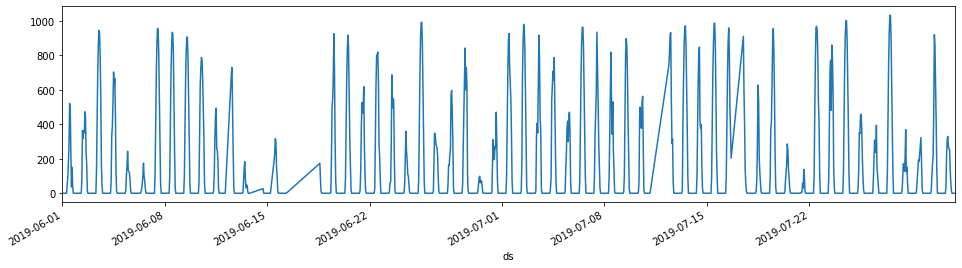

In [223]:
data.y.plot()

In [224]:
train, test = data[:"2019-07-24"].copy(), data["2019-07-25":].copy()

In [225]:
regressors = ["nub", "hour", "day"]

In [226]:
train_X, train_y = train[regressors], train.y
test_X, test_y = test[regressors], test.y

In [227]:
model = RandomForestRegressor(n_estimators=1000)

In [228]:
model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [229]:
forecast = model.predict(test_X)

In [230]:
forecast = pd.Series(forecast, index=test_y.index)

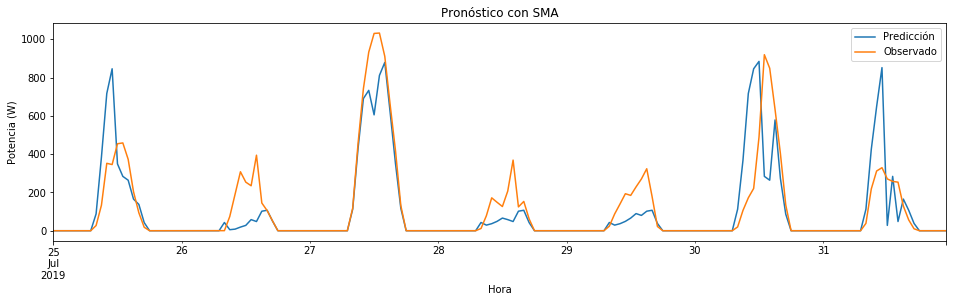

In [231]:
forecast.plot()
test_y.plot()
plt.title("Pronóstico con SMA")
plt.xlabel("Hora")
plt.ylabel("Potencia (W)")
plt.legend(["Predicción", "Observado"])

In [232]:
performance(test_y, forecast)

(147.92975139686428, 67.03929070245033)

In [146]:
performance(test_y, forecast)

(148.2940711916328, 67.08184193674197)

# DecARIMA

In [9]:
data = prepare_data(orig_data, dummies=True)

In [10]:
train, test = split_data(data, split_dt="2019-07-25")

In [11]:
regressors = list(data.drop(columns=["ds", "y"]).columns)

In [14]:
train.isna().sum()

ds         0
y        138
nub_1      0
nub_2      0
nub_3      0
nub_4      0
nub_5      0
nub_6      0
nub_7      0
nub_8      0
nub_9      0
dtype: int64

In [12]:
model = DecARIMA()

In [ ]:
model.fit(train)

In [56]:
df_k = model.decompose(train)[12]